詳解ディープラーニング第2版より

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optimizers
from pdb import set_trace as st

epoch:1, loss:0.159, val_loss:0.120
Validation loss decreased (inf --> 0.120052). Saving model ...
epoch:2, loss:0.091, val_loss:0.064
Validation loss decreased (0.120052 --> 0.064157). Saving model ...
epoch:3, loss:0.051, val_loss:0.036
Validation loss decreased (0.064157 --> 0.035657). Saving model ...
epoch:4, loss:0.031, val_loss:0.025
Validation loss decreased (0.035657 --> 0.024570). Saving model ...
epoch:5, loss:0.019, val_loss:0.019
Validation loss decreased (0.024570 --> 0.018818). Saving model ...
epoch:6, loss:0.014, val_loss:0.013
Validation loss decreased (0.018818 --> 0.012873). Saving model ...
epoch:7, loss:0.010, val_loss:0.008
Validation loss decreased (0.012873 --> 0.007506). Saving model ...
epoch:8, loss:0.009, val_loss:0.005
Validation loss decreased (0.007506 --> 0.005189). Saving model ...
epoch:9, loss:0.009, val_loss:0.005
EarlyStopping Counter: 1 out of 10
epoch:10, loss:0.008, val_loss:0.006
EarlyStopping Counter: 2 out of 10
epoch:11, loss:0.007, val_loss

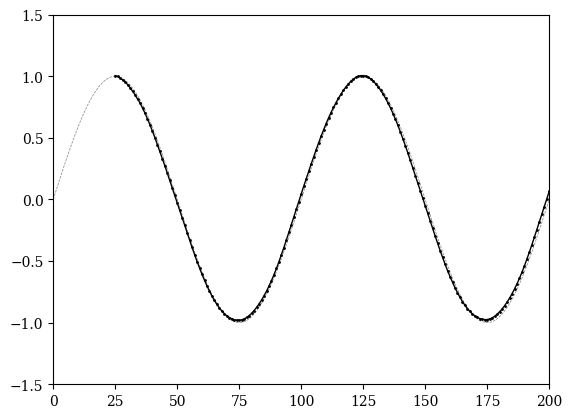

In [ ]:
class  EarlyStopping: # valの値が更新されないときに早期終了
    def __init__(self, patience=5, verbose=False, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.path = path

    def __call__(self, val_loss, model):
        score = - val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping Counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

class RNN(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.l1 = nn.RNN(1, hidden_dim,
                         nonlinearity="tanh",
                         batch_first=True)
        self.l2 = nn.Linear(hidden_dim, 1)
        nn.init.xavier_normal_(self.l1.weight_ih_l0)
        nn.init.orthogonal_(self.l1.weight_hh_l0)

    def forward(self, x):
        h, _ = self.l1(x)
        y = self.l2(h[:,-1])
        return y

if __name__ == '__main__':
    np.random.seed(124)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def sin(x, T=100):
        return np.sin(2.0 * np.pi * x / T)
    
    def toy_problem(T=100, ampl=0.05):
        x = np.arange(0, 2*T + 1)
        noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
        return sin(x)+noise
    
    T = 100
    f = toy_problem(T).astype(np.float32)
    length_of_sequences = len(f)

    maxlen = 25

    x=[]
    t=[]

    for i in range(length_of_sequences - maxlen):
        x.append(f[i:i+maxlen])
        t.append(f[i+maxlen])

    # st() #検証用
    x = np.array(x).reshape(-1, maxlen, 1) # (batch_size, sequence_length, input_size) ここでは(176, 25, 1)
    t = np.array(t).reshape(-1, 1)

    x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.2, shuffle=False)

    model = RNN(50).to(device)

    criterion = nn.MSELoss(reduction="mean")
    optimizer = optimizers.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.009), amsgrad=True)

    def compute_loss(t, y):
        return criterion(y, t)
    
    def train_step(x, t):
        x = torch.Tensor(x).to(device)
        t = torch.Tensor(t).to(device)
        model.train() # torchではtrainとval時に使い分け必要
        preds = model(x) # model(x)とすることで勝手にforwardが呼び出される
        loss = compute_loss(t, preds) 
        optimizer.zero_grad() # torchでは勾配が記憶されるため、リセット必要
        loss.backward() # 勾配を計算
        optimizer.step() # 勾配を保存
        return loss, preds
    
    def val_step(x, t):
        x = torch.Tensor(x).to(device)
        t = torch.Tensor(t).to(device)
        model.eval()
        preds = model(x)
        loss = criterion(preds, t)
        return loss, preds
    
    epochs = 500
    batch_size = 100

    n_batches_train = x_train.shape[0] // batch_size + 1
    n_batches_val = x_val.shape[0] // batch_size + 1

    hist = {"loss":[], "val":[]}
    es = EarlyStopping(patience=10, verbose=True)

    for epoch in range(epochs):
        train_loss = 0.
        val_loss = 0.
        x_, t_ = shuffle(x_train, t_train)

        for batch in range(n_batches_train):
            start = batch * batch_size
            end = start + batch_size
            loss, _ = train_step(x_[start:end], t_[start:end])
            train_loss += loss.item()
        
        for batch in range(n_batches_val):
            start = batch * batch_size
            end = start + batch_size
            loss, _ = val_step(x_val[start:end], t_val[start:end])
            val_loss += loss.item()

        train_loss /= n_batches_train
        val_loss /= n_batches_val

        hist["loss"].append(train_loss)
        hist["val"].append(val_loss)

        print("epoch:{}, loss:{:.3f}, val_loss:{:.3f}".format(epoch+1, train_loss, val_loss))
        
        if es(val_loss, model):
            break

    model.eval()

    sin = toy_problem(T, ampl=0.)
    gen = [None for i in range(maxlen)]

    z = x[:1]

    for i in range(length_of_sequences - maxlen):
        z_ = torch.Tensor(z[-1:]).to(device)
        preds = model(z_).data.cpu().numpy()
        z = np.append(z, preds)[1:] # ex)z=6だとしたら[1,2,3,4,5] -> [2,3,4,5,6]
        z = z.reshape(-1, maxlen, 1)
        gen.append(preds[0, 0])

    # 予測値を可視化
    fig = plt.figure()
    plt.rc("font", family="serif")
    plt.xlim([0, 2*T])
    plt.ylim([-1.5, 1.5])
    plt.plot(range(len(f)), sin, color="gray", linestyle="--", linewidth=0.5)
    plt.plot(range(len(f)), gen, color="black", linewidth=1, marker="o", markersize=1, markerfacecolor="black", markeredgecolor="black")
    plt.show()


In [ ]:
t = torch.tensor(0.4903, requires_grad=True)
print(t.item())

gen = [i for i in range(10)]
print(gen)
z = gen[:1]
print(z)

0.4902999997138977
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0]


In [73]:
x = np.arange(0, 2*T + 1)
# print(x)

def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)
y = sin(x)
# print(y)
x=[]
t=[]

for i in range(length_of_sequences - maxlen):
    x.append(f[i:i+maxlen])
    t.append(f[i+maxlen])

x = np.array(x).reshape(-1,25,1)
print(x[:,1,0])

[ 0.08733767  0.13256459  0.18320543  0.23716047  0.28641593  0.3849208
  0.4153268   0.45991096  0.56381875  0.5976947   0.59971863  0.67350453
  0.77646744  0.7672731   0.77303416  0.7985348   0.8991063   0.9163876
  0.9700497   0.96331984  0.94459534  0.98783904  0.9826133   0.9622023
  1.0077746   1.0006789   1.0359716   1.0281751   1.0170263   0.92415214
  0.8894844   0.8794019   0.89538246  0.8140711   0.8419697   0.75512594
  0.7303701   0.7006629   0.68078643  0.5444753   0.56051576  0.47078192
  0.42935514  0.32416746  0.34815258  0.27647725  0.20439328  0.1488385
  0.07916047 -0.03182337 -0.02649076 -0.13019034 -0.17240834 -0.2827527
 -0.31841883 -0.3382394  -0.40286386 -0.52466327 -0.50885546 -0.58806366
 -0.61073184 -0.66657126 -0.7659426  -0.75463885 -0.8344841  -0.86978275
 -0.8425111  -0.944278   -0.9071333  -0.90648794 -0.9464167  -1.0178974
 -0.9628094  -0.97713137 -0.952753   -0.9502752  -0.99211484 -0.966718
 -0.9917063  -0.93780756 -0.8945752  -0.8979308  -0.9239681